# World Bank Official Boundaries Import
Source: https://datacatalog.worldbank.org/dataset/world-bank-official-boundaries

Import of world Bank-approved administrative level 0 boundaries (ignoring disputed areas, coastlines and lakes). We also include simplified boundary GeoJSON's for application building.

Simplifed maps are also generated using the scales used for [geojsons_low_res](https://github.com/datacommonsorg/data/blob/master/scripts/us_census/geojsons_low_res/generate_mcf.py#L40) import. There are also additional levels of simplification added here if required.

**Notebook setup**
---

In [13]:
project_id = 'datcom-data'
import_name = 'WorldBankBoundaries'
DEBUG = False

In [14]:
from google.colab import auth

auth.authenticate_user()


!gcloud config set project {project_id}

Updated property [core/project].


In [15]:
#@title
!pip install datacommons
import pandas as pd
import numpy as np
!pip install git+git://github.com/geopandas/geopandas.git
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-tw5r8rw9
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-tw5r8rw9


In [16]:
#@title Download data from source

import io
import zipfile
import requests

DOWNLOAD_URI = 'https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/779551/wb_boundaries_geojson_highres.zip'
TMP_PATH = '/tmp/wb_boundaries_geojson_highres'
GCS_BUCKET = f'gs://unresolved_mcf/template_mcf_imports/{import_name}'

r = requests.get(DOWNLOAD_URI, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(TMP_PATH)

!gsutil -m cp -r {TMP_PATH} {GCS_BUCKET}

Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Admin0_boundary_lines.geojson [Content-Type=application/octet-stream]...
Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Admin0_disputed_areas.geojson [Content-Type=application/octet-stream]...
Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Land.geojson [Content-Type=application/octet-stream]...
Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Coastlines.geojson [Content-Type=application/octet-stream]...
Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_countries_Admin0.geojson [Content-Type=application/octet-stream]...
Copying file:///tmp/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Admin0_disputed_areas_boundary_lines.geojson [Content-Type=application/octet-stream]...
\ [6/6 files][100.6 MiB/100.6 MiB] 100% Done                                    
O

In [17]:
GEO_JSON_PATH = f'{TMP_PATH}/WB_Boundaries_GeoJSON_highres/WB_countries_Admin0.geojson'

all_countries = gpd.read_file(GEO_JSON_PATH)

**Data validation**
---

In [18]:
#@title
import json

# aa0_boundary_geojson_gcs = 'gs://unresolved_mcf/template_mcf_imports/WorldBankBoundaries/wb_boundaries_geojson_highres/WB_Boundaries_GeoJSON_highres/WB_Admin0_boundary_lines.geojson'

GEO_JSON_PATH = f'{TMP_PATH}/WB_Boundaries_GeoJSON_highres/WB_countries_Admin0.geojson'
with open(GEO_JSON_PATH) as fp:
  geo_json = json.load(fp)
  print(geo_json["crs"]["properties"].get("name", "-n/a"))

  areas = {}
  for feature in geo_json["features"]:
    props = feature.get("properties", {})
    areas.setdefault(props['TYPE'], []).append(props)

WB_ISO_PROP = 'ISO_A3'
wb_a3 = set()

wb_code_to_props = {}
wb_unknowns = []
for (t, features) in areas.items():
  print(f'\n\n{t}\n')
  for f in features:
  # for f in sorted(features):
    code = f[WB_ISO_PROP]
    print(f'{f["ISO_A3"]}\t{f["WB_A3"] if f["WB_A3"] != code else "==="}\t{f["WB_NAME"]}')
    wb_a3.add(code)
    # wb_a3.add(f["WB_NAME"])
    wb_code_to_props[code] = f
    if code == "-99":
      wb_unknowns.append(f)
    # print(f)
    # print(f.get('FORMAL_EN'))
print("Unknowns")
for f in wb_unknowns:
  print(f'{f["ISO_A3"]}\t{f["WB_A3"]}\t{f["WB_NAME"]}\t{f}')

EPSG:4326


Sovereign country

IDN	===	Indonesia
MYS	===	Malaysia
CHL	===	Chile
BOL	===	Bolivia
PER	===	Peru
ARG	===	Argentina
CYP	===	Cyprus
IND	===	India
LBN	===	Lebanon
ETH	===	Ethiopia
SSD	===	South Sudan
SOM	===	Somalia
KEN	===	Kenya
PAK	===	Pakistan
MWI	===	Malawi
TZA	===	Tanzania
SYR	===	Syrian Arab Republic
SUR	===	Suriname
GUY	===	Guyana
KOR	===	Korea, Republic of
PRK	===	Korea, Democratic People's Republic of
MAR	===	Morocco
CRI	===	Costa Rica
NIC	===	Nicaragua
COG	===	Congo, Rep. of
COD	ZAR	Congo, Democratic Republic of
BTN	===	Bhutan
UKR	===	Ukraine
BLR	===	Belarus
NAM	===	Namibia
ZAF	===	South Africa
OMN	===	Oman
UZB	===	Uzbekistan
KAZ	===	Kazakhstan
TJK	===	Tajikistan
LTU	===	Lithuania
BRA	===	Brazil
URY	===	Uruguay
MNG	===	Mongolia
RUS	===	Russian Federation
CZE	===	Czech Republic
DEU	===	Germany
EST	===	Estonia
LVA	===	Latvia
-99	NOR	Norway
SWE	===	Sweden
VNM	===	Vietnam
KHM	===	Cambodia
LUX	===	Luxembourg
ARE	===	United Arab Emirates
BEL	===	Belgium
GEO	===	Georgia
MKD

In [19]:
%load_ext google.colab.data_table

all_countries.head()

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


FID  OBJECTID  ...  Shape_Area                                           geometry
0    0         1  ...  153.078608  MULTIPOLYGON (((117.70361 4.16341, 117.73943 4...
1    1         2  ...   26.703172  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...
2    2         3  ...   76.761813  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...
3    3         4  ...   92.203587  POLYGON ((-69.51009 -17.50659, -69.50611 -17.5...
4    4         5  ...  106.417089  MULTIPOLYGON (((-69.51009 -17.50659, -69.51009...

[5 rows x 54 columns]

Investigate which column to build dcid country codes with.

In [20]:
import datacommons as dc

dc_all_countries = dc.query('''
SELECT ?place ?name WHERE {
  ?place typeOf Country .
  ?place name ?name
}
''', select=None)

for f in filter(lambda x: not x['?place'].startswith('country/'), dc_all_countries):
  print(f)

{'?place': 'wikidataId/Q31354462', '?name': 'Republic of Abkhazia'}
{'?place': 'wikidataId/Q27304761', '?name': 'Asgardia'}
{'?place': 'wikidataId/Q29999', '?name': 'Kingdom of the Netherlands'}
{'?place': 'wikidataId/Q244165', '?name': 'Artsakh'}
{'?place': 'wikidataId/Q23681', '?name': 'Turkish Republic of Northern Cyprus'}
{'?place': 'wikidataId/Q756617', '?name': 'Kingdom of Denmark'}
{'?place': 'wikidataId/Q40362', '?name': 'Sahrawi Arab Democratic Republic'}


In [21]:
def is_dc_country(iso):
  dcid = f'country/{iso}'
  matches = filter(lambda x: x['?place'] == dcid, dc_all_countries)
  return len(list(matches)) > 0

print(is_dc_country('USA'))
print(is_dc_country('ZAR'))

True
False


In [22]:
code_names = all_countries[['ISO_A3', 'WB_A3', 'WB_NAME']]

In [23]:
code_names['ISO_IN_DC'] = code_names['ISO_A3'].apply(is_dc_country)
code_names['WB_IN_DC'] = code_names['WB_A3'].apply(is_dc_country)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
code_names[code_names['ISO_IN_DC'] == False]

ISO_A3 WB_A3                         WB_NAME  ISO_IN_DC  WB_IN_DC
20     -99   FRA                          France      False      True
50     -99   NOR                          Norway      False      True
62     -99   KSV                          Kosovo      False     False
129    -99   USA             Guantanamo Bay (US)      False      True
232    -99   FRA         Clipperton Island (Fr.)      False      True
238    -99   CCK  Cocos (Keeling) Islands (Aus.)      False      True
239    -99   CXR         Christmas Island (Aus.)      False      True

In [25]:
code_names[code_names['WB_IN_DC'] == False]

ISO_A3 WB_A3                        WB_NAME  ISO_IN_DC  WB_IN_DC
29     COD   ZAR  Congo, Democratic Republic of       True     False
62     -99   KSV                         Kosovo      False     False
71     ROU   ROM                        Romania       True     False
114    TLS   TMP                    Timor-Leste       True     False
124    AND   ADO                        Andorra       True     False
209    IMN   IMY               Isle of Man (UK)       True     False

In [26]:
code_names[code_names['ISO_A3'] != code_names['WB_A3']]

ISO_A3 WB_A3                         WB_NAME  ISO_IN_DC  WB_IN_DC
20     -99   FRA                          France      False      True
29     COD   ZAR   Congo, Democratic Republic of       True     False
50     -99   NOR                          Norway      False      True
62     -99   KSV                          Kosovo      False     False
71     ROU   ROM                         Romania       True     False
114    TLS   TMP                     Timor-Leste       True     False
124    AND   ADO                         Andorra       True     False
129    -99   USA             Guantanamo Bay (US)      False      True
209    IMN   IMY                Isle of Man (UK)       True     False
232    -99   FRA         Clipperton Island (Fr.)      False      True
234    NLD   BES                 Bonaire (Neth.)       True      True
235    NLD   BES          Sint Eustatius (Neth.)       True      True
236    NLD   BES                    Saba (Neth.)       True      True
238    -99   CCK  Cocos (Keeling) Islands (Aus.)      False      True
239    -99   CXR         Christmas Island (Aus.)      False      True
246    UMI   USA             Navassa Island (US)       True      True
249    NZL   TKL                    Tokelau (NZ)       True      True

In [27]:
ISO_A3_CODES_TO_IMPORT = ['COD', 'ROU', 'TLS', 'AND', 'IMN', 'UMI', 'USA']

In [35]:
import_countries = set(code_names['WB_A3']).union(ISO_A3_CODES_TO_IMPORT)

Conclusion - use WB_A3 for country codes since for the most part are smaller, more specific regions, with fallback to ISO_A3 from ISO_A3_CODES_TO_IMPORT.

UMI and USA is included in that list since their ISO_A3 codes are more aligned with DC.

Also prefer BES over NLD.

In [36]:
#@title

WB_A3_CODES_TO_IMPORT = ['BES', 'TKL', 'FRA', 'CCK', 'CXR', 'NOR']

In [37]:
import datacommons as dc

dc_countries = dc.get_places_in(['Earth'], 'Country').get('Earth', [])
print(dc_countries)
print(len(dc_countries))

dict(filter(lambda item: len(item[1]) > 0, dc.get_property_values(dc_countries, 'dissolutionDate').items()))

['country/ABW', 'country/AFG', 'country/AGO', 'country/AIA', 'country/ALB', 'country/AND', 'country/ANT', 'country/ARE', 'country/ARG', 'country/ARM', 'country/ASM', 'country/ATA', 'country/ATB', 'country/ATF', 'country/ATG', 'country/ATN', 'country/AUS', 'country/AUT', 'country/AZE', 'country/BDI', 'country/BEL', 'country/BEN', 'country/BES', 'country/BFA', 'country/BGD', 'country/BGR', 'country/BHR', 'country/BHS', 'country/BIH', 'country/BLM', 'country/BLR', 'country/BLZ', 'country/BMU', 'country/BOL', 'country/BRA', 'country/BRB', 'country/BRN', 'country/BTN', 'country/BVT', 'country/BWA', 'country/CAF', 'country/CAN', 'country/CCK', 'country/CHE', 'country/CHL', 'country/CHN', 'country/CIV', 'country/CMR', 'country/COD', 'country/COG', 'country/COK', 'country/COL', 'country/COM', 'country/CPV', 'country/CRI', 'country/CTE', 'country/CUB', 'country/CUW', 'country/CXR', 'country/CYM', 'country/CYP', 'country/CZE', 'country/DEU', 'country/DJI', 'country/DMA', 'country/DNK', 'country/

{'country/YUG': ['1992-04-26']}

In [38]:
#@title DC countries without maps
dc_country_codes = set(map(lambda x: x[-3:], dc_countries))
dc_country_codes.discard('YUG')
dc_country_codes.add('SSD')

dc_countries_not_in_wb = dc_country_codes - import_countries
dc.get_property_values(map(lambda x: f'country/{x}', list(dc_countries_not_in_wb)), 'name')


{'country/ANT': ['Netherlands Antilles'],
 'country/ATA': ['Antarctica'],
 'country/ATB': ['British Antarctic Territory'],
 'country/ATN': ['Dronning Maud Land'],
 'country/BVT': ['Bouvet Island'],
 'country/CTE': ['Canton and Enderbury Islands'],
 'country/ESH': ['Western Sahara'],
 'country/FXX': ['Metropolitan France'],
 'country/GLP': ['Guadeloupe'],
 'country/GUF': ['French Guiana'],
 'country/MTQ': ['Martinique'],
 'country/MYT': ['Mayotte'],
 'country/REU': ['Réunion'],
 'country/SJM': ['Svalbard and Jan Mayen'],
 'country/TWN': ['Taiwan'],
 'country/XKS': ['Kosovo']}

In [39]:
#@title
for col in ['featurecla', 'LEVEL', 'TYPE', 'ECONOMY', 'INCOME_GRP', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB']:
  print(f'{col}:\t{sorted(all_countries[col].unique())}')

featurecla:	['Admin-0 country']
LEVEL:	[2]
TYPE:	['Country', 'Dependency', 'Disputed', 'Lease', 'Sovereign country']
ECONOMY:	['1. Developed region: G7', '2. Developed region: nonG7', '3. Emerging region: BRIC', '4. Emerging region: MIKT', '5. Emerging region: G20', '6. Developing region', '7. Least developed region']
INCOME_GRP:	['1. High income: OECD', '2. High income: nonOECD', '3. Upper middle income', '4. Lower middle income', '5. Low income']
CONTINENT:	['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'Seven seas (open ocean)', 'South America']
REGION_UN:	['Africa', 'Americas', 'Asia', 'Europe', 'Oceania', 'Seven seas (open ocean)']
SUBREGION:	['Australia and New Zealand', 'Caribbean', 'Central America', 'Central Asia', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Melanesia', 'Micronesia', 'Middle Africa', 'Northern Africa', 'Northern America', 'Northern Europe', 'Polynesia', 'Seven seas (open ocean)', 'South America', 'South-Eastern Asia', 'Southern Africa', 'Sou

**Verifying this visually**
---

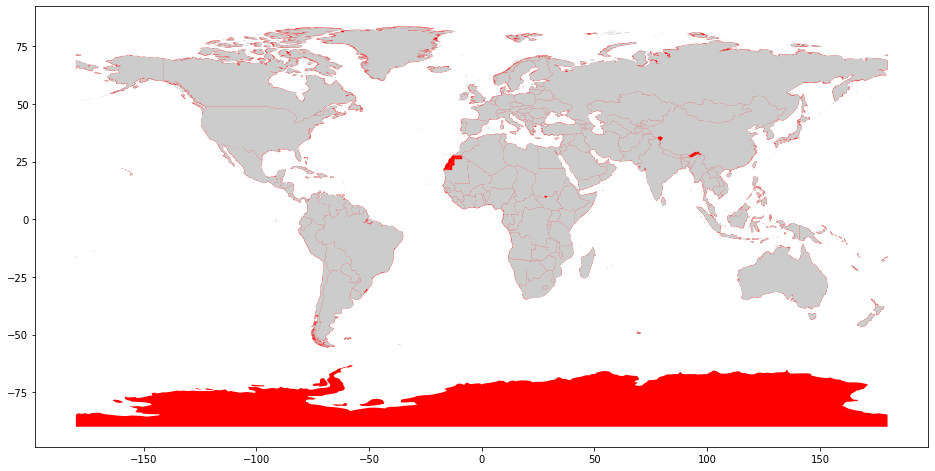

In [40]:
#@title Comparing World Bank's boundaries with another data source
naturalearth = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(16, 16))
naturalearth.plot(ax=ax, color='red')
all_countries.plot(ax=ax, color="#cccccc")
plt.show()

Using ISO_A3


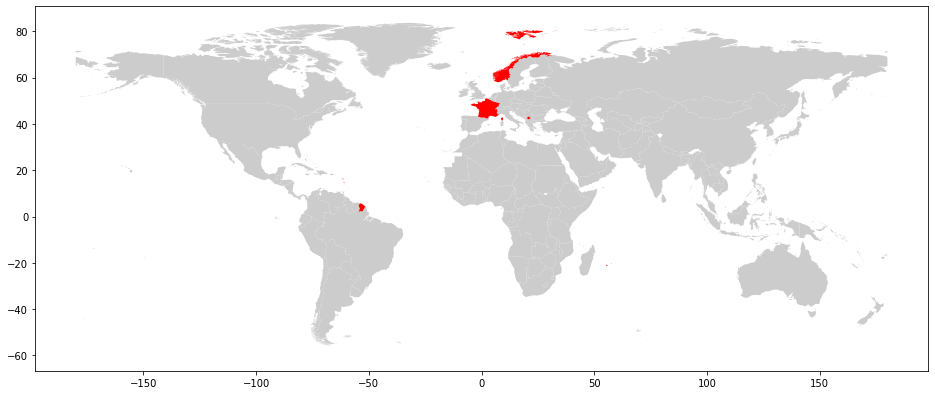

{'-99'}
Using WB_A3


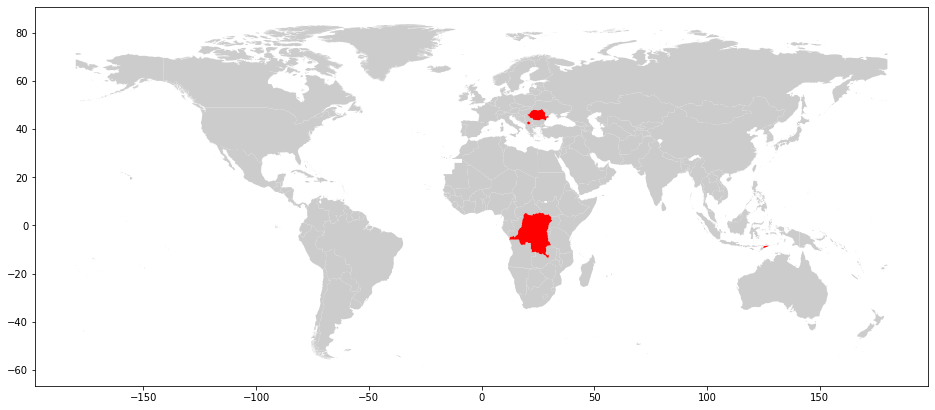

{'IMY', 'KSV', 'ADO', 'ROM', 'ZAR', 'TMP'}


In [41]:
#@title Verifying coverage between country codes in the dataset
for code in ['ISO_A3', 'WB_A3']:
  print(f'Using {code}')
  fig, ax = plt.subplots(figsize=(16, 16))
  all_countries[all_countries[code].isin(dc_country_codes)].plot(ax=ax, color='#cccccc')
  all_countries[all_countries[code].isin(set(all_countries[code]) - dc_country_codes)].plot(ax=ax, color='red')
  plt.show()

  print(set(all_countries[code]) - dc_country_codes)

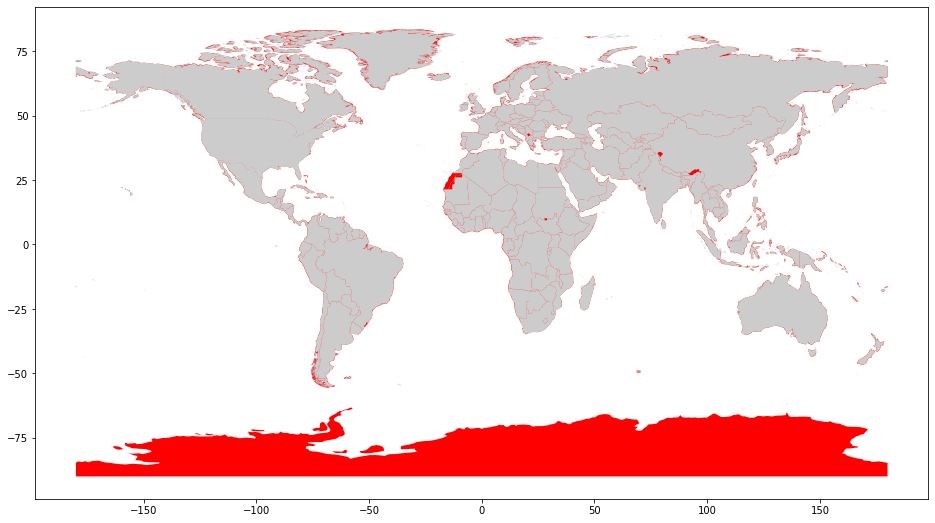

In [43]:
#@title Testing coverage with import codes
fig, ax = plt.subplots(figsize=(16, 16))
naturalearth.plot(ax=ax, color='red')
all_countries[all_countries['WB_A3'].isin(dc_country_codes)].plot(ax=ax, color="#cccccc")
all_countries[all_countries['ISO_A3'].isin(ISO_A3_CODES_TO_IMPORT)].plot(ax=ax, color='#cccccc')
plt.show()

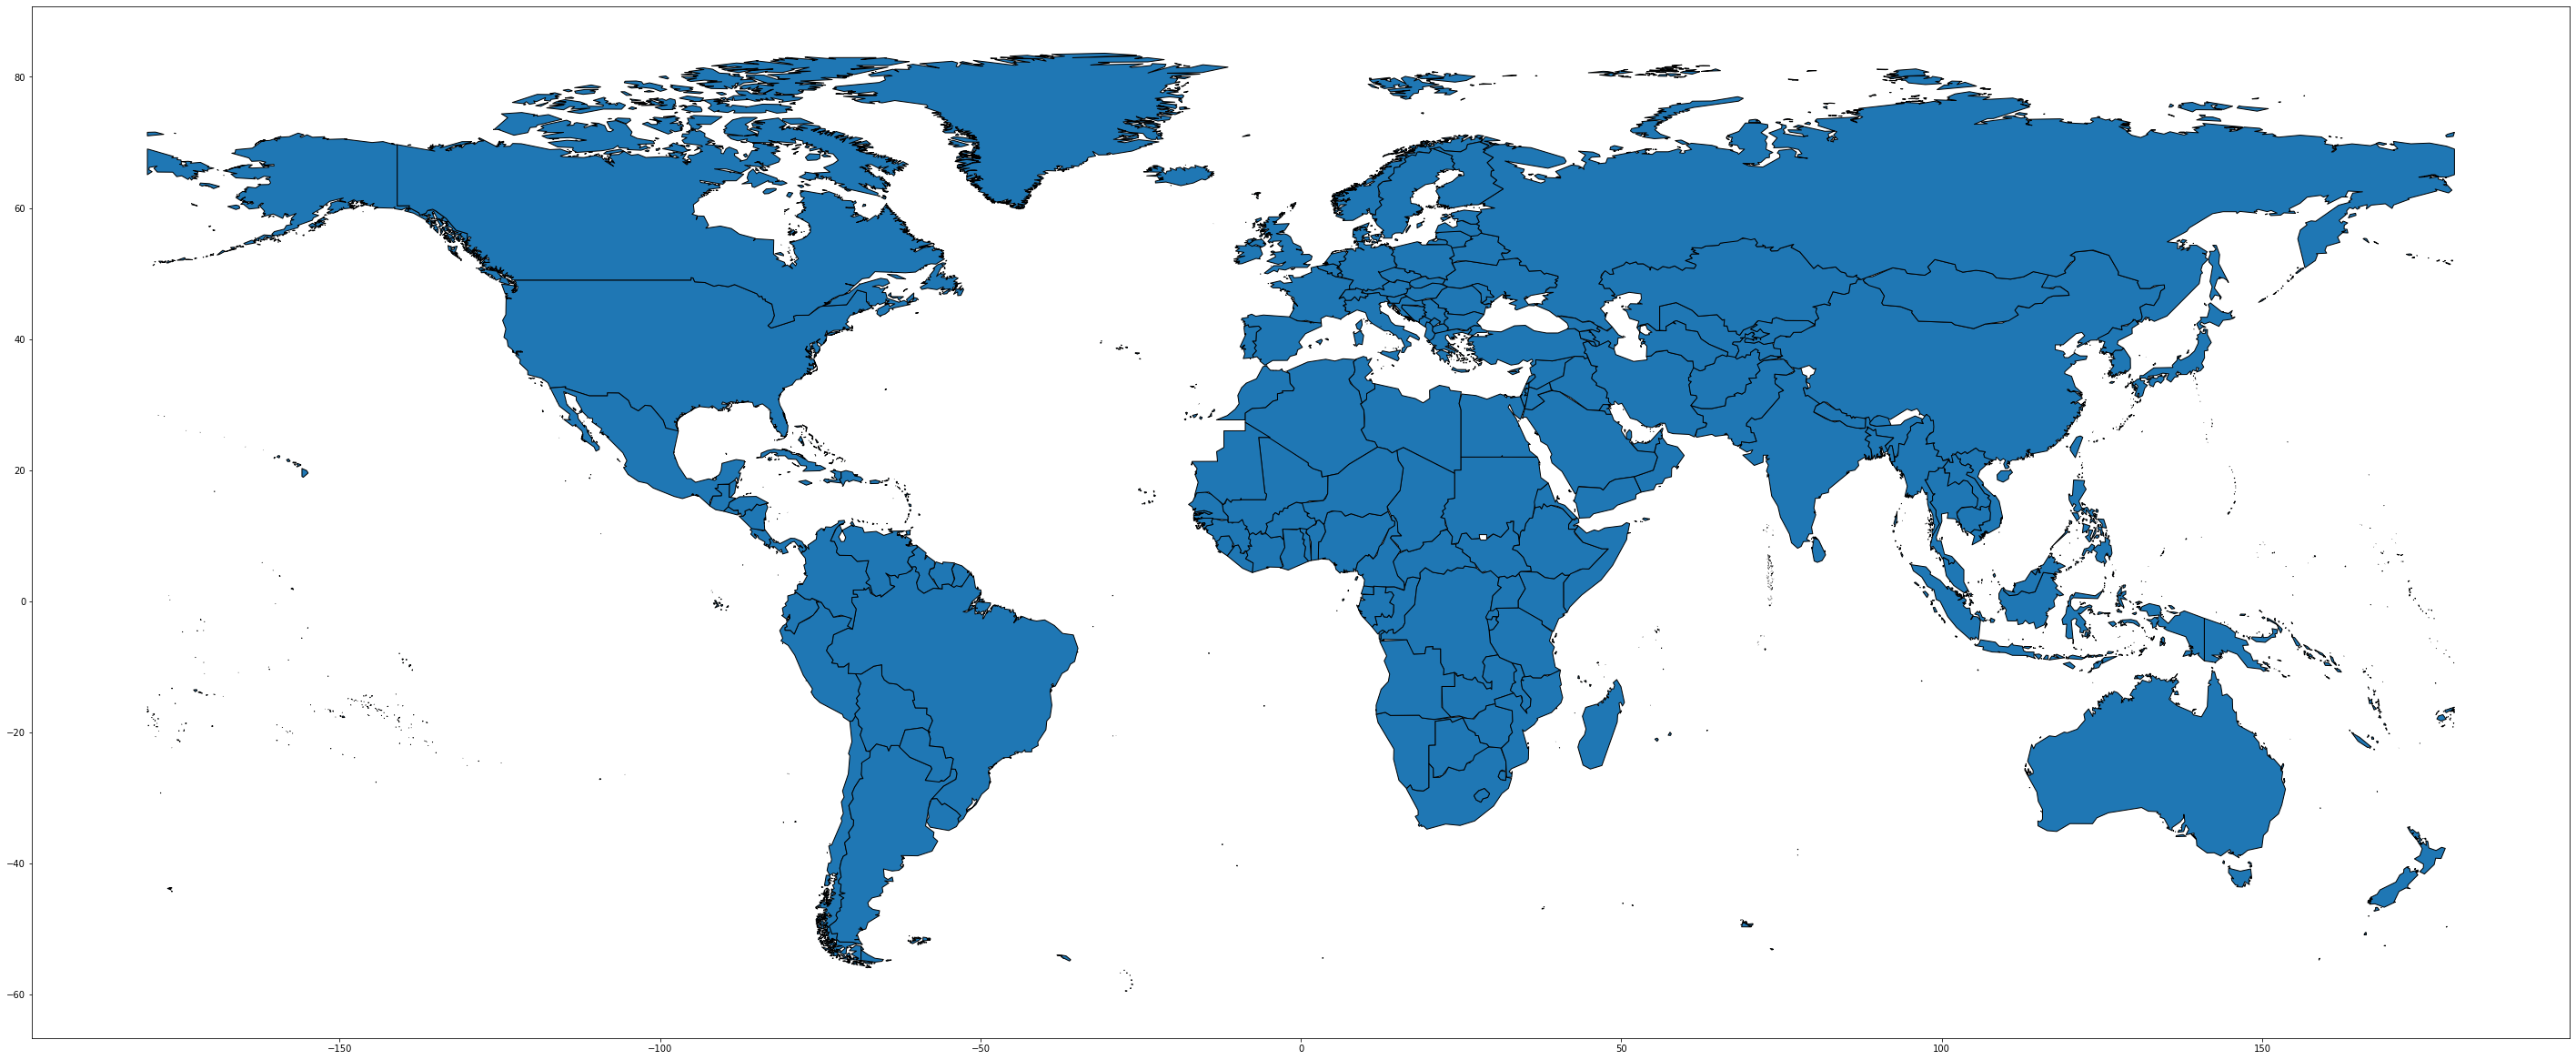

In [44]:
#@title Testing for acceptable thresholds
all_countries.simplify(0.2).plot(figsize=(50,50), color=None, linewidth=1, edgecolor='k')

**Generating individual country geo jsons**
---

In [46]:
EXPORT_PATH = '/tmp/exports'
!mkdir -p {EXPORT_PATH}

def export_country_feature(country_code, country_data, dp_level):

  fname = f'{EXPORT_PATH}/{country_code}_{dp_level}.geojson'
  country_data.to_file(fname, driver='GeoJSON')
  if DEBUG:
    print(f'= Importing {country_code} {dp_level} =')
    gpd.read_file(fname).plot(figsize=(5,5))
    plt.show()
    print()

In [53]:
code = 'WB_A3'
dp_level = '0'
for country_code in sorted(all_countries[code].unique()):
  country_data = all_countries[all_countries[code] == country_code]
  export_country_feature(country_code, country_data, dp_level)

for country_code in sorted(ISO_A3_CODES_TO_IMPORT):
  country_data = all_countries[all_countries['ISO_A3'] == country_code]
  export_country_feature(country_code, country_data, dp_level)

In [54]:
def country_code_from_fpath(fpath):
  return fpath[len(EXPORT_PATH)+1:-len("_0.geojson")]

ADO	is_in_dc=False
IMY	is_in_dc=False
KSV	is_in_dc=False
ROM	is_in_dc=False
TMP	is_in_dc=False
ZAR	is_in_dc=False


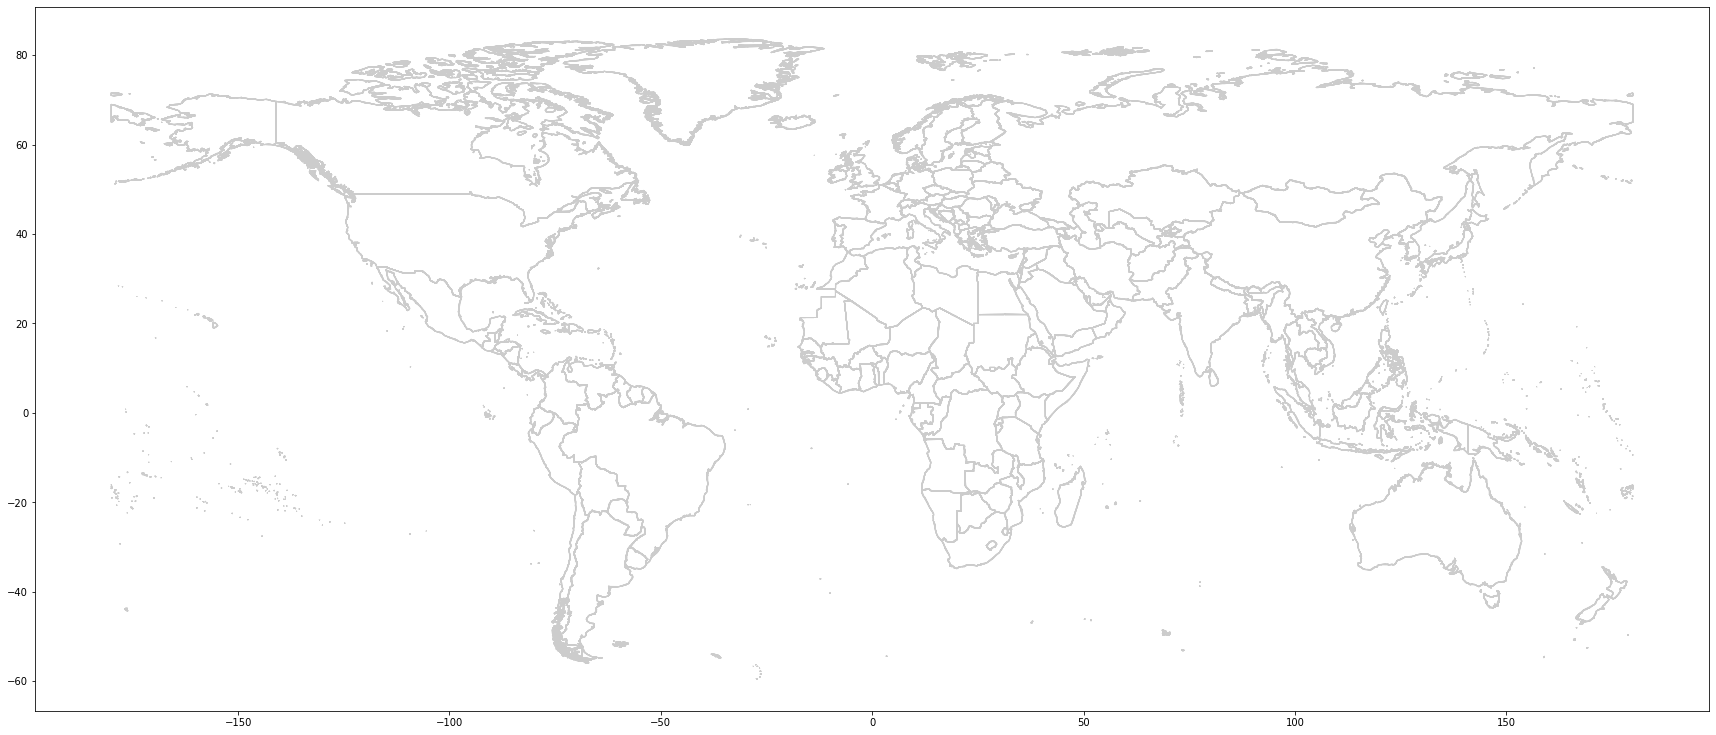

In [60]:
#@title Assembling world map from individual geojson files
import glob

exported_countries = set()

fig, ax = plt.subplots(figsize = (30,30)) 
for fpath in sorted(glob.glob(f'{EXPORT_PATH}/*.geojson')):
  country_code = country_code_from_fpath(fpath)
  exported_countries.add(country_code)
  in_dc = is_dc_country(country_code)
  if not in_dc:
    print(f'{country_code}\tis_in_dc={in_dc}')
    continue
  gpd.read_file(fpath).geometry.boundary.plot(color='#cccccc', edgecolor='k', linewidth=1, ax=ax)

In [56]:
#@title Testing the output of an individual geojson
#@markdown Note that it still includes all the features / data from the data source
with open(f'{EXPORT_PATH}/ABW_0.geojson') as f:
  # geostr = f.read()
  geostr = json.load(f)
  # Note: the double use of json.dumps automatically escapes all
  # inner quotes, and encloses the entire string in quotes.
  print(json.dumps(json.dumps(geostr)))


"{\"type\": \"FeatureCollection\", \"crs\": {\"type\": \"name\", \"properties\": {\"name\": \"urn:ogc:def:crs:OGC:1.3:CRS84\"}}, \"features\": [{\"type\": \"Feature\", \"properties\": {\"FID\": 171, \"OBJECTID\": 172, \"featurecla\": \"Admin-0 country\", \"LEVEL\": 2, \"TYPE\": \"Country\", \"FORMAL_EN\": \"Aruba\", \"FORMAL_FR\": \" \", \"POP_EST\": 115120, \"POP_RANK\": 9, \"GDP_MD_EST\": 2516.0, \"POP_YEAR\": 2017, \"LASTCENSUS\": 2010, \"GDP_YEAR\": 2009, \"ECONOMY\": \"6. Developing region\", \"INCOME_GRP\": \"2. High income: nonOECD\", \"FIPS_10_\": \"AA\", \"ISO_A2\": \"AW\", \"ISO_A3\": \"ABW\", \"ISO_A3_EH\": \"ABW\", \"ISO_N3\": \"533\", \"UN_A3\": \"533\", \"WB_A2\": \"AW\", \"WB_A3\": \"ABW\", \"CONTINENT\": \"North America\", \"REGION_UN\": \"Americas\", \"SUBREGION\": \"Caribbean\", \"REGION_WB\": \"Latin America & Caribbean\", \"NAME_AR\": \"\\u0623\\u0631\\u0648\\u0628\\u0627\", \"NAME_BN\": \"\\u0986\\u09b0\\u09c1\\u09ac\\u09be\", \"NAME_DE\": \"Aruba\", \"NAME_EN\": \

**Generate simplified geo jsons**
---

In [57]:
EPS_LEVEL_MAP = {0.01: 1, 0.03: 2, 0.05: 3, 0.075: 4, 0.1: 5, 0.125: 6, 0.15: 7, 0.175: 8, 0.2: 9} # from https://github.com/datacommonsorg/data/blob/master/scripts/us_census/geojsons_low_res/generate_mcf.py

for fpath in sorted(glob.glob(f'{EXPORT_PATH}/*_0.geojson')):
  country_code = country_code_from_fpath(fpath)
  in_dc = is_dc_country(country_code)
  if not in_dc:
    continue
  for tolerance, dp_level in EPS_LEVEL_MAP.items():
    country_data = gpd.read_file(fpath).simplify(tolerance)
    export_country_feature(country_code, country_data, dp_level)

Tolerance=0.01	DP-level=1


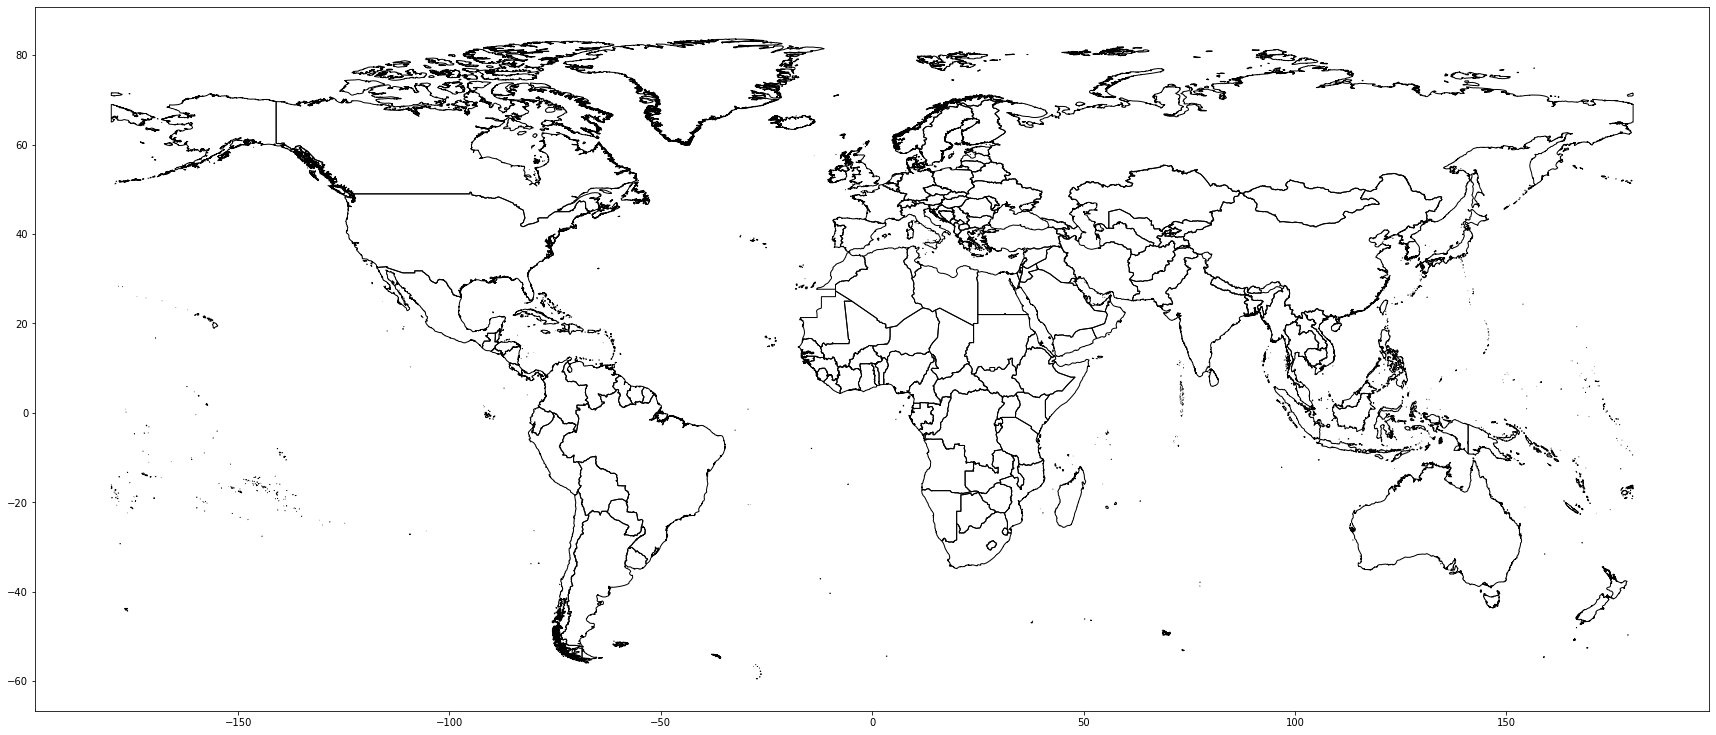

Tolerance=0.03	DP-level=2


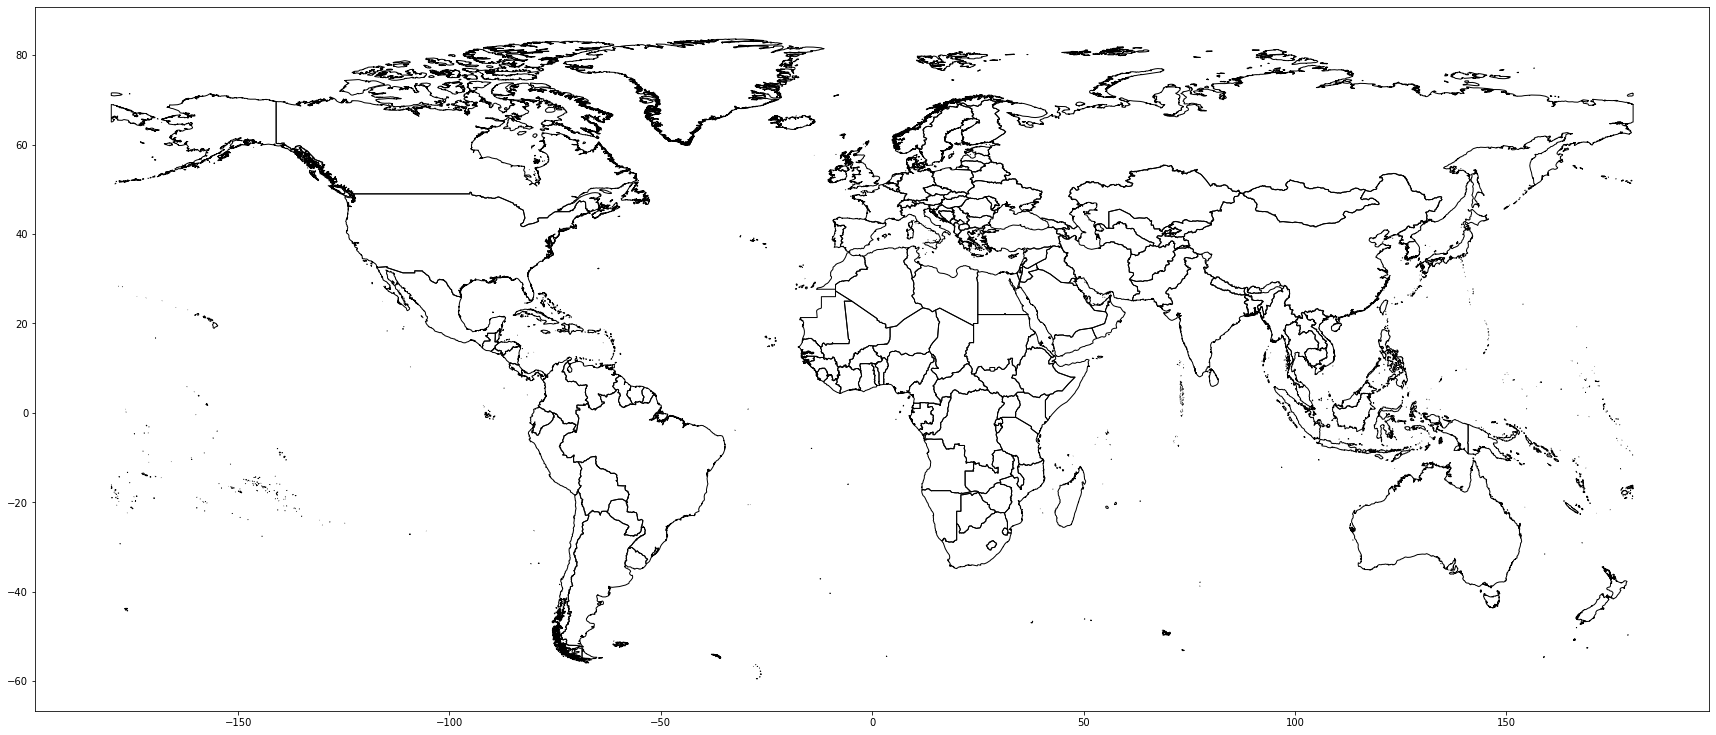

Tolerance=0.05	DP-level=3


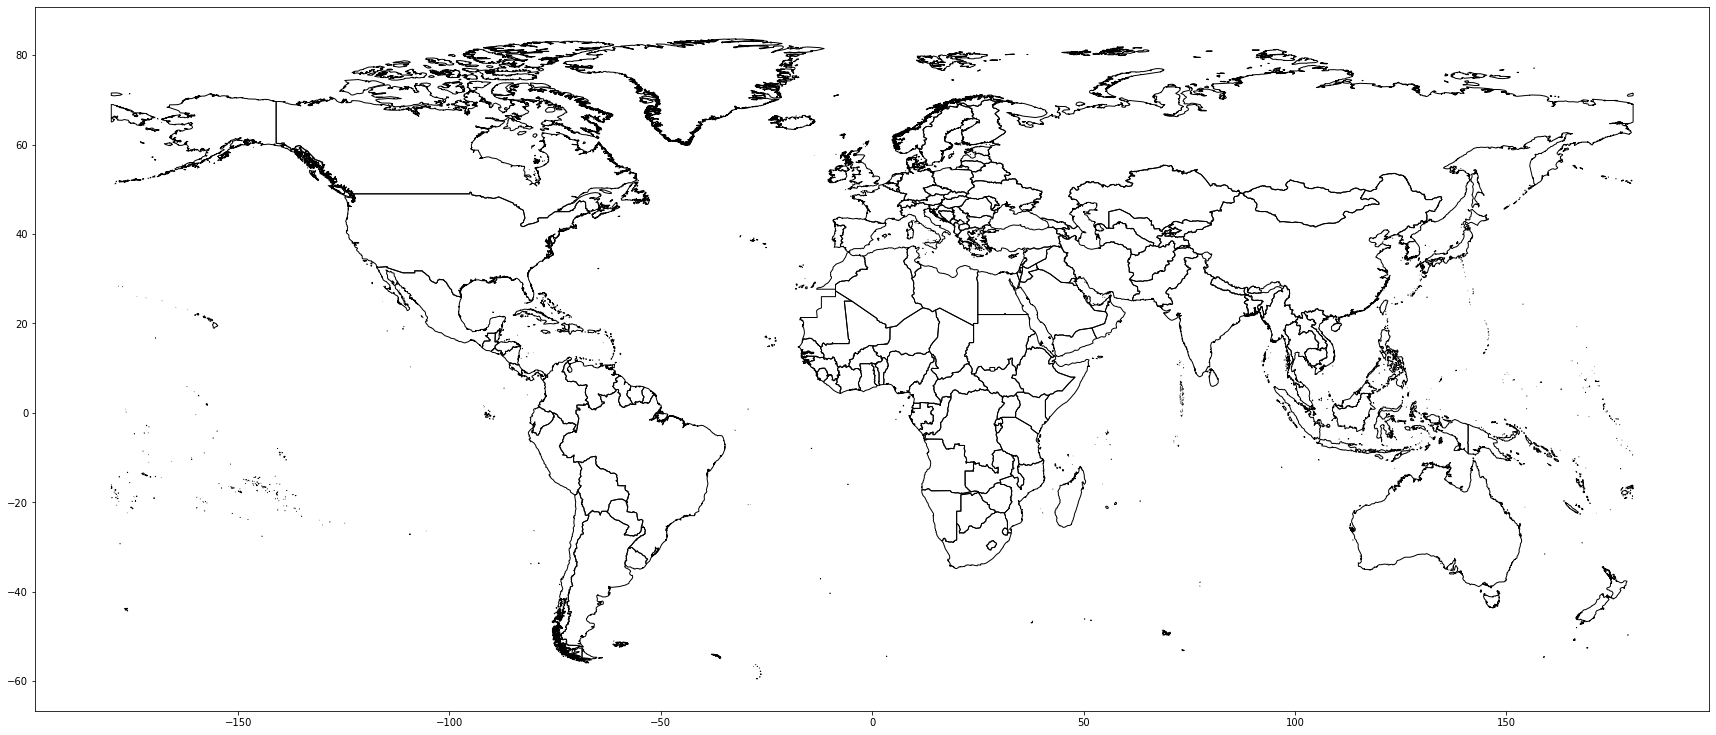

Tolerance=0.075	DP-level=4


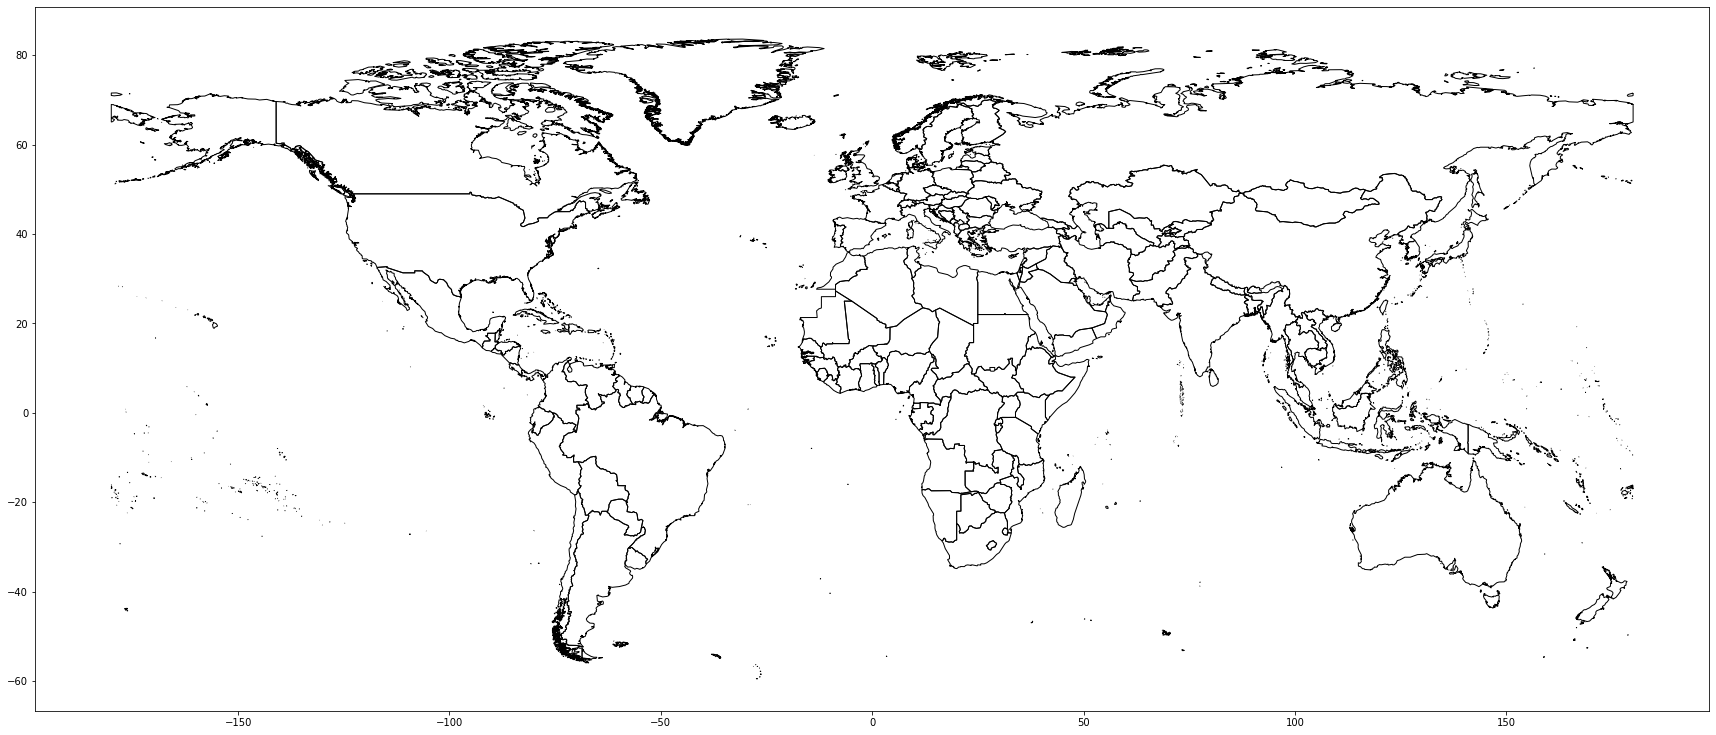

Tolerance=0.1	DP-level=5


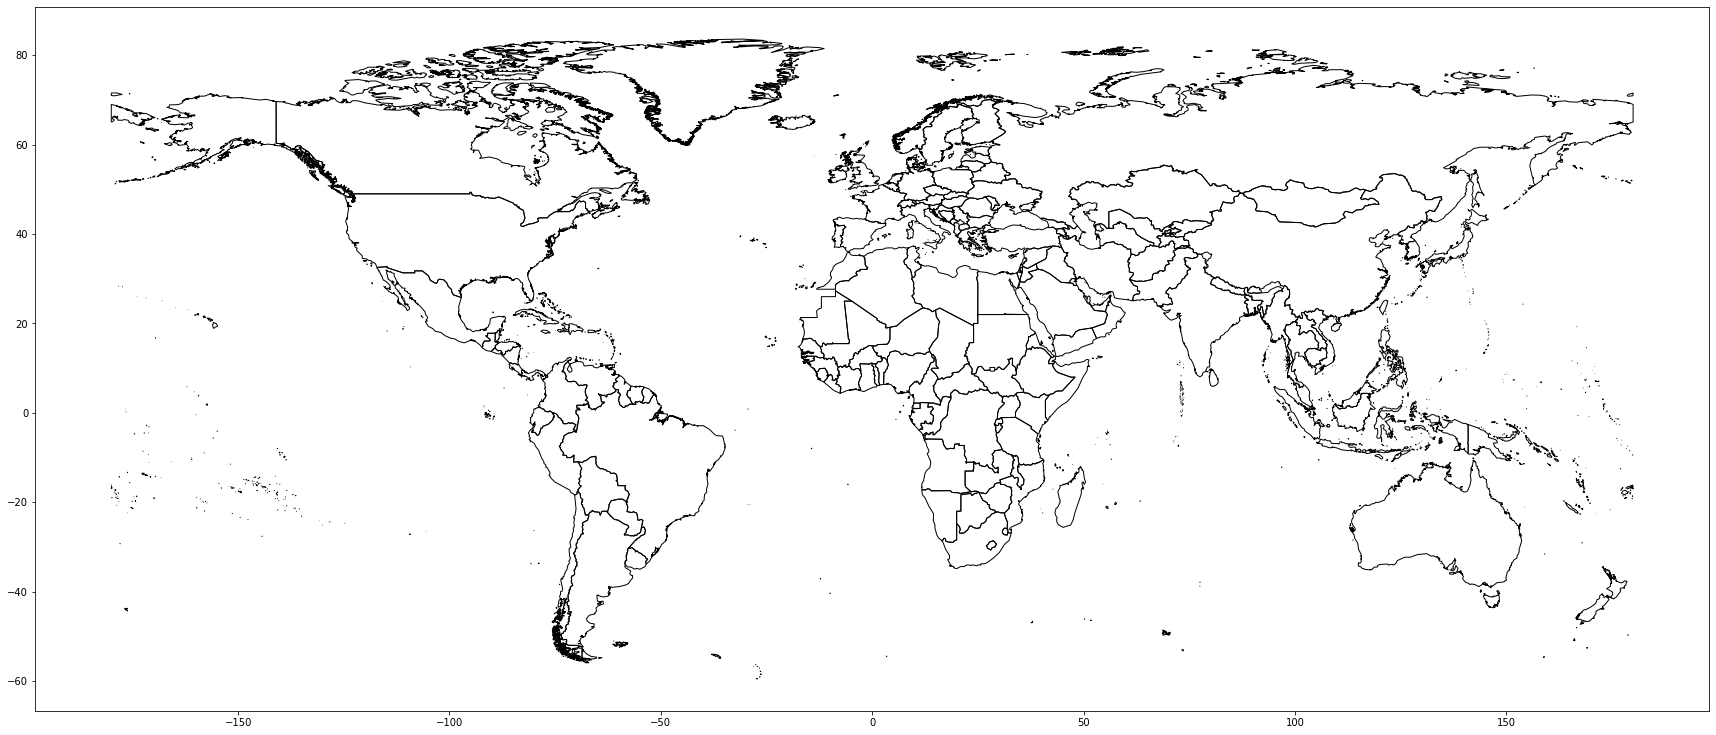

Tolerance=0.125	DP-level=6


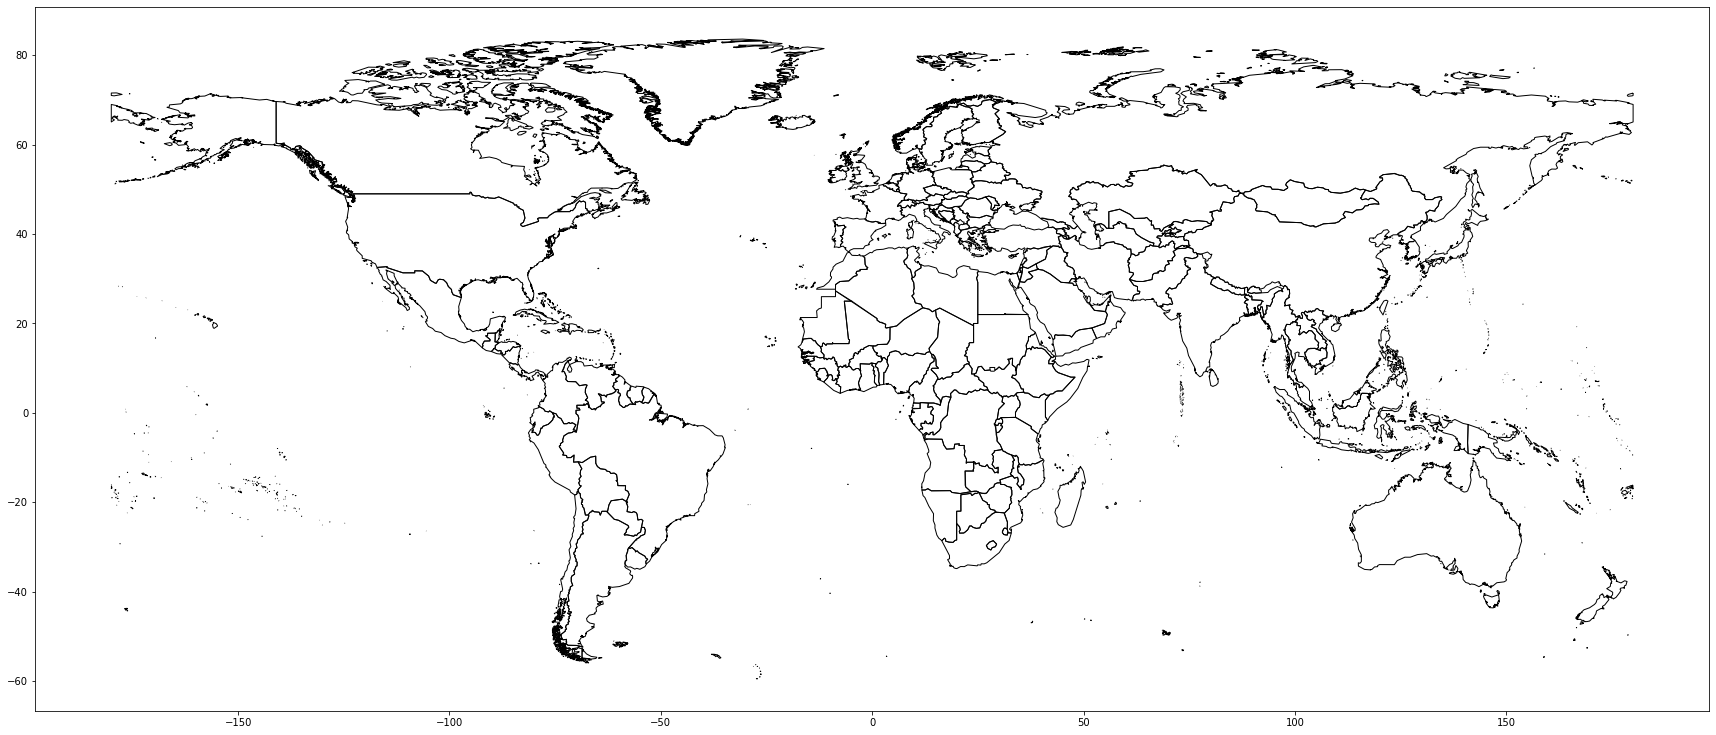

Tolerance=0.15	DP-level=7


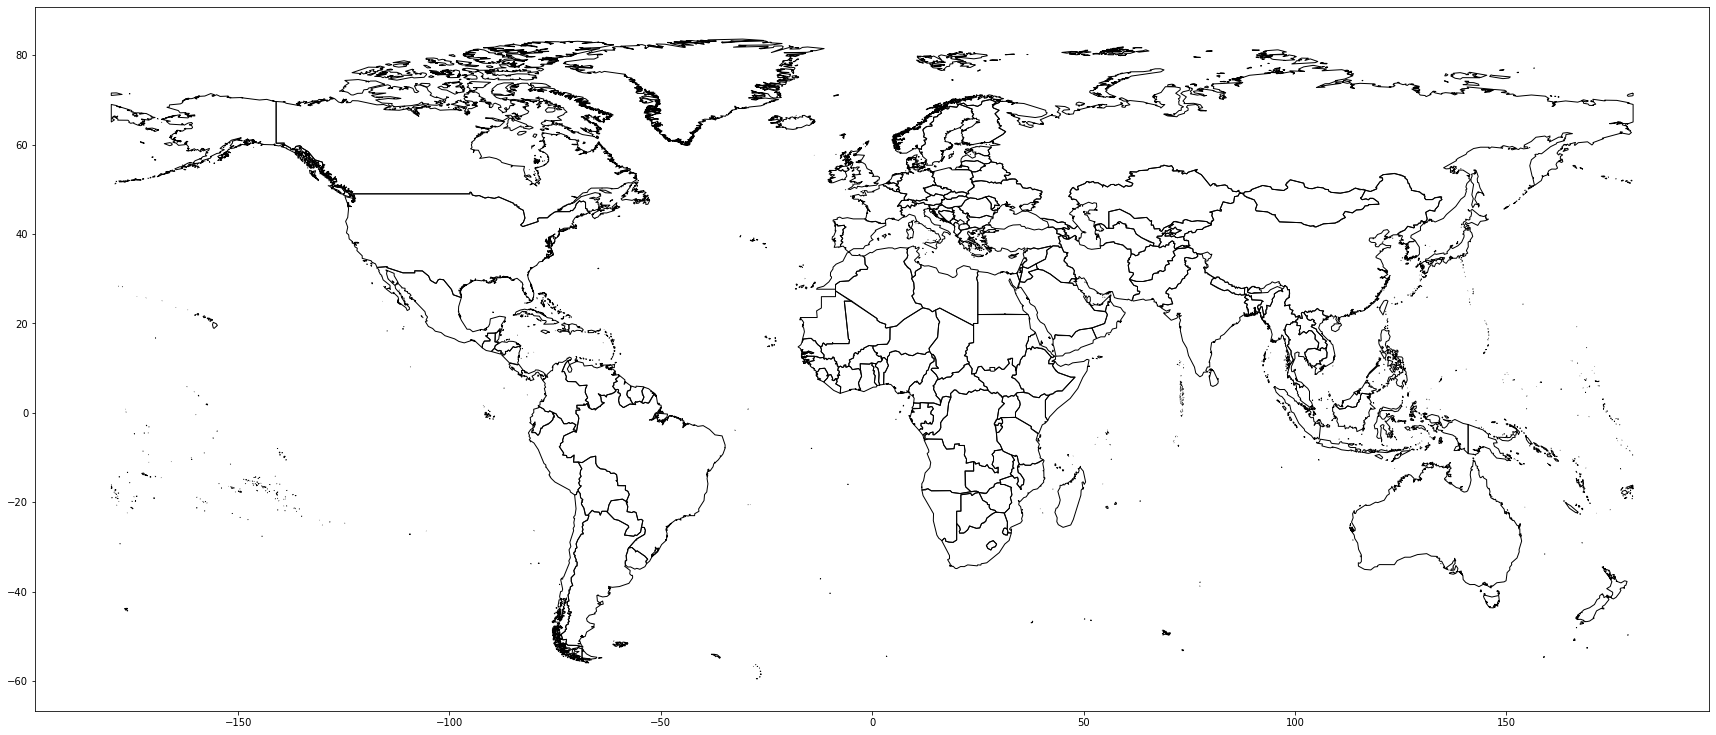

Tolerance=0.175	DP-level=8


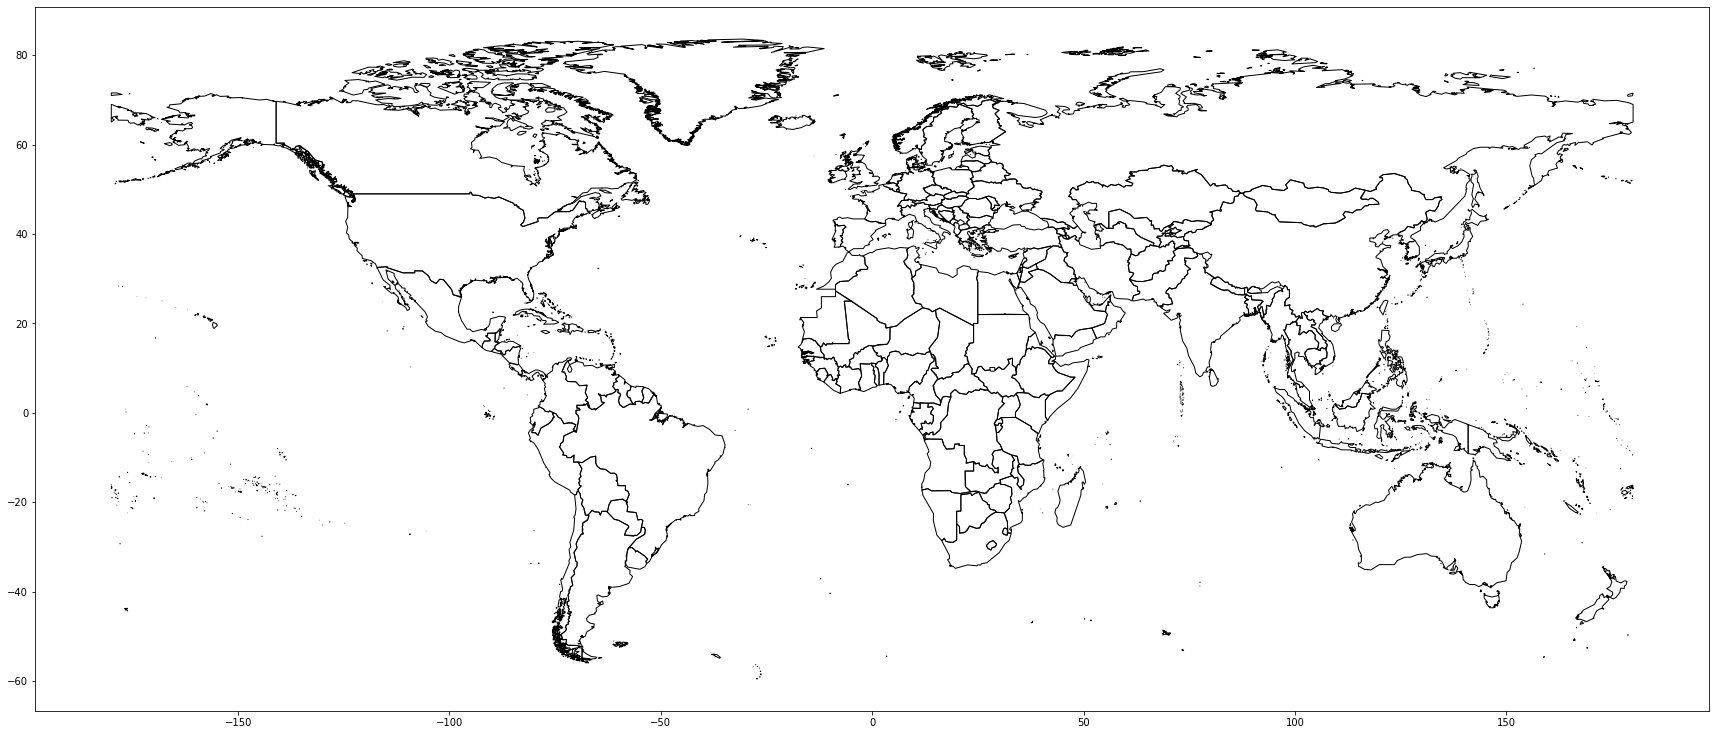

Tolerance=0.2	DP-level=9


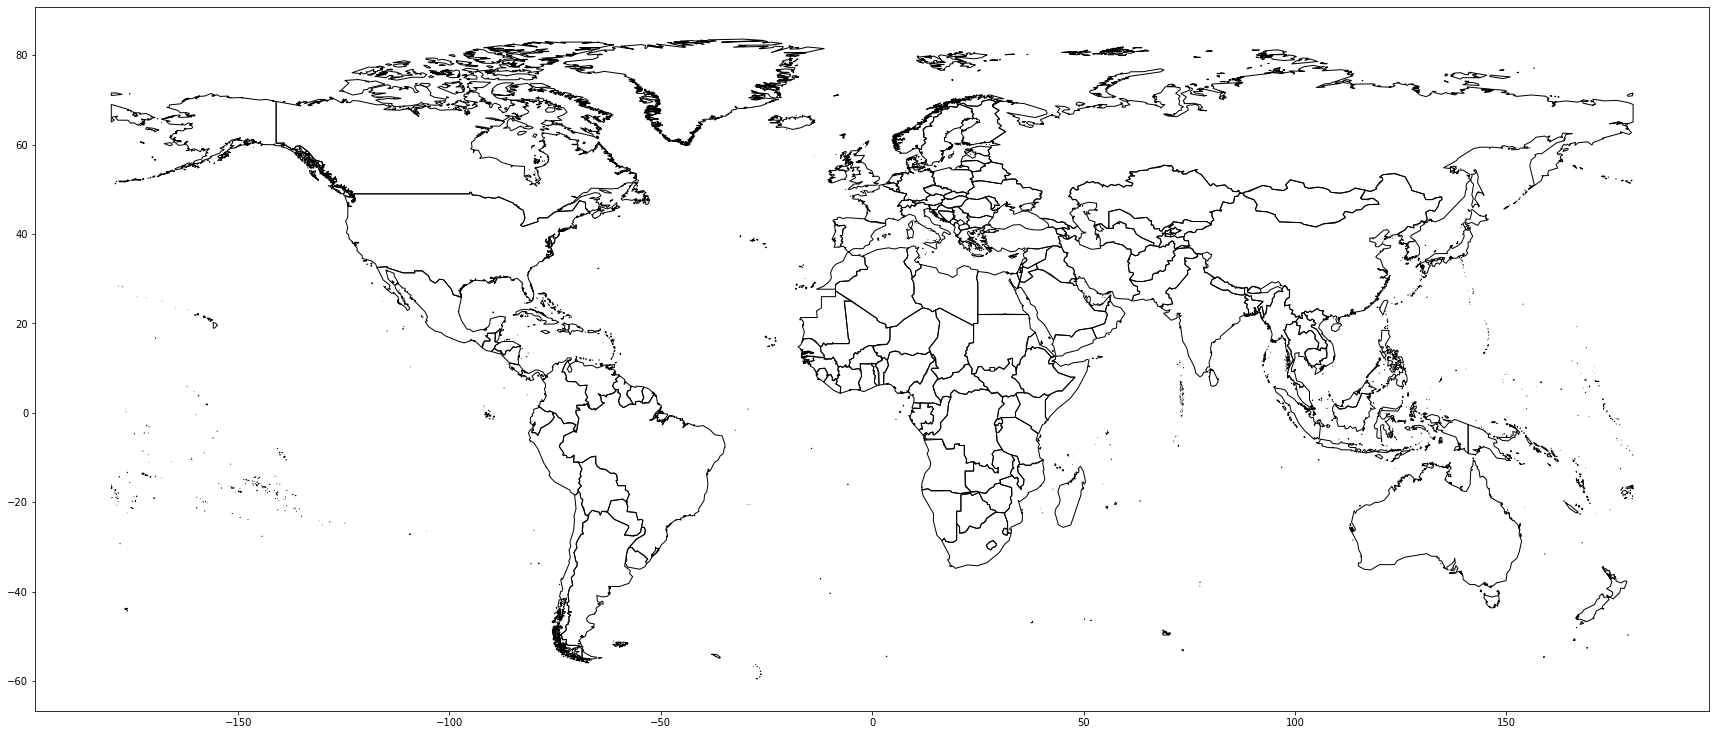

In [58]:
#@title Assembling world map from individual simplified geojson files

for tolerance, dp_level in EPS_LEVEL_MAP.items():
  print(f'Tolerance={tolerance}\tDP-level={dp_level}')
  fig, ax = plt.subplots(figsize = (30,30)) 
  for fpath in sorted(glob.glob(f'{EXPORT_PATH}/*_{dp_level}.geojson')):
    country_code = country_code_from_fpath(fpath)
    exported_countries.add(country_code)
    in_dc = is_dc_country(country_code)
    if not in_dc:
      continue
    gpd.read_file(fpath).geometry.boundary.plot(color=None, edgecolor='k', linewidth=1, ax=ax)
  plt.show()